あるストリーミングサービスの解約率を調べるという状況を想定する  
まずはデータ生成を行う  

ここで解約率を推定するために利用できるデータは以下のものとする。

| 項目 | 説明 | 分布 | コメント |
| --- | --- | --- | --- |
| DaysSinceLastActivity | 最終ログインからの日数 | 指数分布: 平均10日 | 幽霊アカウントを含めたらこんな感じか？
| HasActivePromotionalOffer | 復帰を促したか | 二項分布: 0 or 1 | -- |
| AverageSessionDuration | 平均セッション時間 | ガンマ分布: (2,15) 平均30分 | 大体の通学時間を想定

In [2]:
using Random

Random.seed!(1234)
n_samples = 1000

1000

10-element Vector{Float64}:
  3.989805872320786
 10.97157487488112
 11.528800883195558
  0.32182180836827007
  9.852672831588938
 14.861479297186445
 44.69383545607664
  3.138659888253987
 10.057130392898497
 16.665226566676623

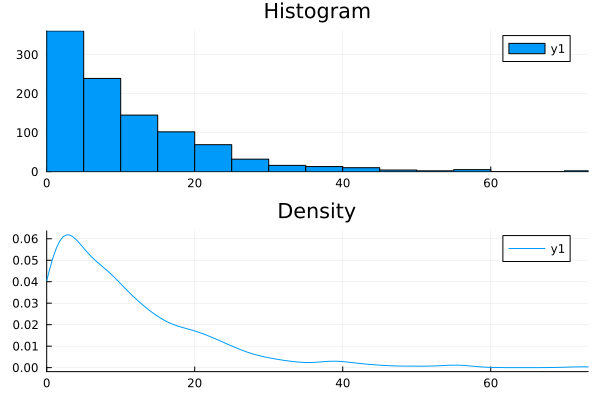

In [3]:
using Distributions
using StatsPlots

DaysSinceLastActivity = rand(Exponential(10), n_samples)
display(first(DaysSinceLastActivity, 10))

xlims_DSA=(0, maximum(DaysSinceLastActivity))
plot(
    histogram(
        DaysSinceLastActivity,
        title="Histogram",
        xlims=xlims_DSA
    ),
    density(
        DaysSinceLastActivity,
        title="Density",
        xlims=xlims_DSA
    ),
    layout=(2,1),
)

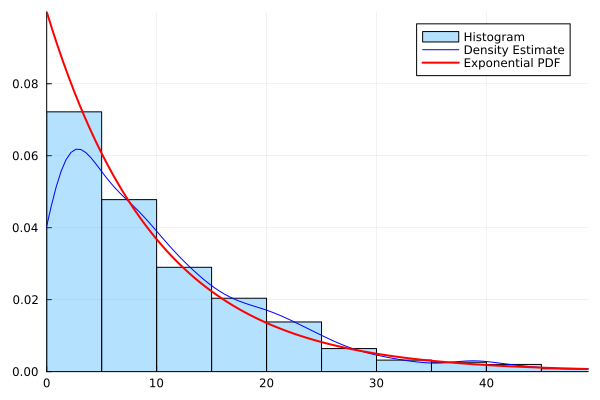

In [4]:
# Combined Histogram and Density plot on the same plot
plots_DaysSinceLastActivity = histogram(
    DaysSinceLastActivity,
    bins=30,
    normalize=true,   # Crucial for density plot
    fillalpha = 0.3,
    linecolor = :black,
    label = "Histogram",
    xlims = (0, quantile(DaysSinceLastActivity, 0.99))
)
density!(
    DaysSinceLastActivity,
    fillalpha = 0.6,
    linecolor = :blue,
    label = "Density Estimate",
)
# 指数関数の確率密度関数
x = range(0, quantile(DaysSinceLastActivity, 0.99), length=100)
plot!(
    x,
    pdf(Exponential(10), x),
    linewidth=2,
    color=:red,
    label="Exponential PDF"
)
display(plots_DaysSinceLastActivity)


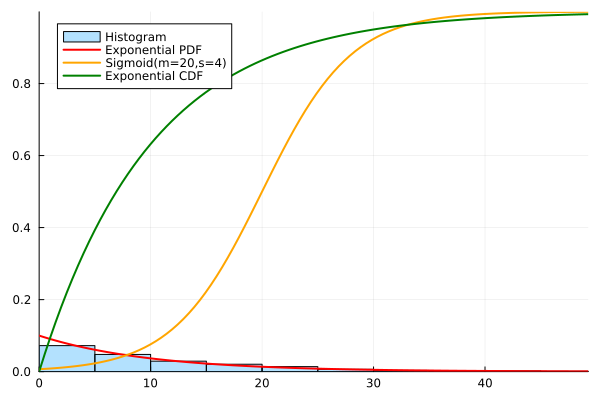

In [5]:
histogram(
    DaysSinceLastActivity,
    bins=30,
    normalize=true,   # Crucial for density plot
    fillalpha = 0.3,
    linecolor = :black,
    label = "Histogram",
    xlims = (0, quantile(DaysSinceLastActivity, 0.99))
)
plot!(
    x,
    pdf(Exponential(10), x),
    linewidth=2,
    color=:red,
    label="Exponential PDF"
)
sigmoid(x, m, s) = 1 ./ (1 .+ exp.(-(x .- m) ./ s))
plot!(
    x,
    sigmoid(x, 20, 4),
    linewidth=2,
    color=:orange,
    label="Sigmoid(m=20,s=4)"
)
plot!(
    x,
    cdf(Exponential(10), x),
    linewidth=2,
    color=:green,
    label="Exponential CDF"
)

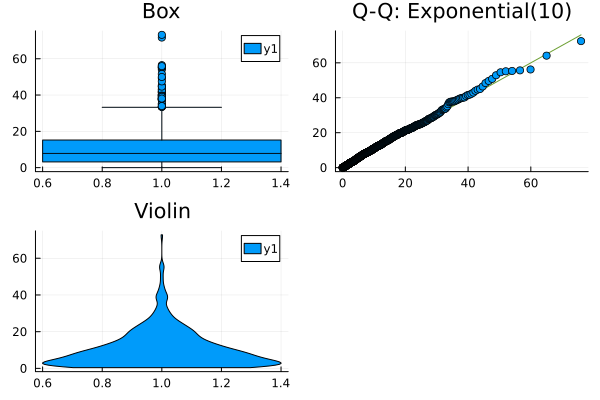

In [6]:
# その他のプロットたち
plot(
    boxplot(
        DaysSinceLastActivity,
        title="Box"
    ),
    qqplot(
        Exponential(10),
        DaysSinceLastActivity,
        title="Q-Q: Exponential(10)",
    ),
    violin(
        DaysSinceLastActivity,
        title="Violin"
    )
)

5-element Vector{Int64}:
 0
 1
 1
 0
 0

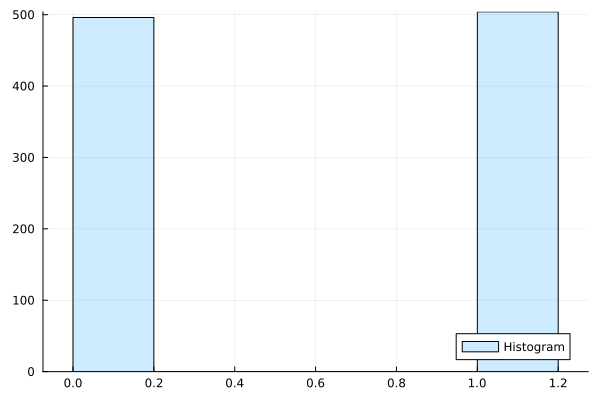

In [7]:
# 次はHasActivePromotionalOffer
HasActivePromotionalOffer = rand([0,1], n_samples)
display(first(HasActivePromotionalOffer, 5))
plots_HasActivePromotionalOffer = histogram(
    HasActivePromotionalOffer,
    fillalpha=0.2,
    label="Histogram"
)
display(plots_HasActivePromotionalOffer)

In [8]:
# AverageSessionDuration
# これはガンマ分布(2,15)
AverageSessionDuration = rand(Gamma(2,15), n_samples)
display(first(AverageSessionDuration, 5))

5-element Vector{Float64}:
 39.26013305811533
 63.38556973255818
 29.298779615357244
 37.88617281099633
 59.433326040070746

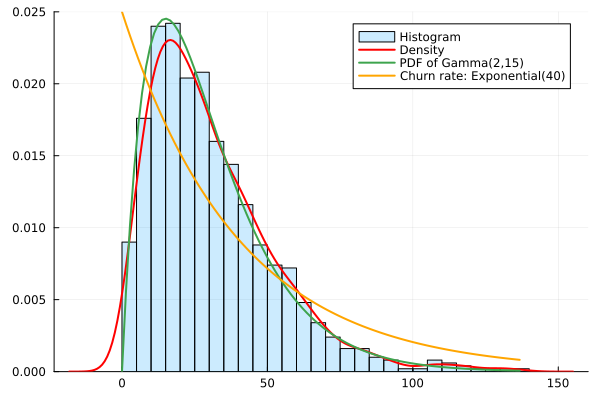

In [9]:
# density & ガンマ分布のpdfも併記
plots_AverageSessionDuration = histogram(
    AverageSessionDuration,
    normalize=true,
    fillalpha=0.2,
    label="Histogram",
)
density!(
    AverageSessionDuration,
    label="Density",
    color="red",
    linewidth=2
)
x = range(0, maximum(AverageSessionDuration), length=100)
plot!(
    x,
    pdf(Gamma(2,15), x),
    label="PDF of Gamma(2,15)",
    linewidth=2
)
lambda = 40
plot!(
    x,
    pdf(Exponential(lambda), x),
    color="orange",
    linewidth=2,
    label="Churn rate: Exponential($lambda)"
)
display(plots_AverageSessionDuration)

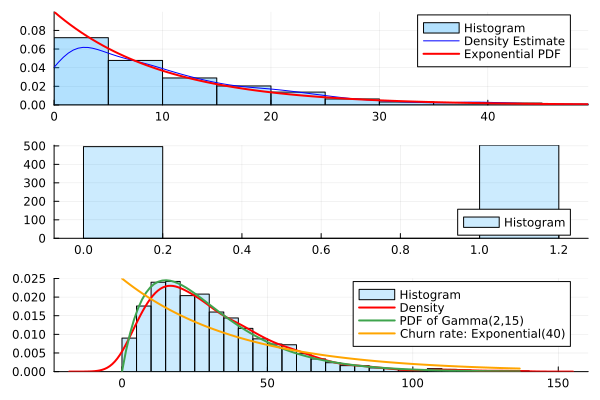

In [10]:
# 3つを並べて表示
plot(
    plots_DaysSinceLastActivity,
    plots_HasActivePromotionalOffer,
    plots_AverageSessionDuration,
    layout=(3,1)
)


# 解約についてのユーザー設定
解約グループと、そうではない通常グループについての設定（振る舞い）を定義する。

# 最終ログインからの時間 (DaysSinceLastActivity)
- DaysSinceLastActivityは指数分布に従うデータ
- 最終ログインからの時間が長いほど解約率が上がる
- 解約率はシグモイド間数でモデル化
  - 変動させるのは中間パラメータmのみ
  - スケールパラメータmの変更は行わない
## 解約グループ
- 解約グループは解約までの判断が早いと想定
- このユーザは見切りが早く、あっさりと他のサービスに乗り換えてしまう
- 通常m=20のところ、このグループの閾値はm=10とする

# プロモーション (HasActivePromotionalOffer)
- HasActivePromotionalOfferは、行うか行わないかのベルヌーイ分布(0.5)
- プロモーション実施はコストの問題のため全員に行うことはできず、実施確率は５０％となっている
## 解約グループ
- プロモーションは実際効果的であった
- 実際、解約グループはプロモーションを全体で２割しか受け取っていない

# セッション時間 (AverageSessionDuration)
- AverageSessionDurationgはガンマ分布に従うデータ
- おおよそこのサービスは平均的に３０分再生されている
- そして解約率は平均再生時間に比例して下がる
  - つまり解約率は平均再生時間の指数分布とモデル化できる
  - 指数関数のlambdaを変更することで解約の度合いを変えられる
## 解約グループ
- 解約グループは平均再生時間が仮に長かったとしても、あっさりと解約を行なってしまう
- 通常が平均５０に対し、解約グループは１０
  - 解約グループは見切りを付けるのが速い
  - 再生時間が短い場合、解約をすることをためらわない

In [11]:
# データの作成は完了
# 次は解約率の設定とそのラベルの作成

labels = zeros(Int, n_samples)

p_churn = 0.1

infl_session_roof = pdf(Exponential(40), 0)
# 解約をシミュレーションしてラベル作成
for i=1:n_samples
    # 最後の活動からの時刻から計算される解約尤度
    infl_activity = sigmoid(DaysSinceLastActivity[i], 20, 4)
    # プロモーションを打っていれば、解約しずらいよう減衰を抑える
    infl_promotion = pdf(Bernoulli(0.4), HasActivePromotionalOffer[i])
    # セッション時間が短いほど解約率は急激に上がる
    infl_session = pdf(Exponential(40), AverageSessionDuration[i])
    churn_influence = p_churn *
        infl_activity *
        infl_promotion *
        infl_session
    no_churn_influence = (1 - p_churn) *
        (1 - infl_activity) *
        (1 - infl_promotion) *
        (infl_session_roof - infl_session)
    influence_norm = churn_influence / (churn_influence + no_churn_influence)
    labels[i] = rand() < influence_norm ? 1 : 0
    println(DaysSinceLastActivity[i], '\t', HasActivePromotionalOffer[i], '\t', AverageSessionDuration[i])
    println(churn_influence, "\t" ,no_churn_influence)
    println("P$i:\t", influence_norm)
end

println("Average churn: $(mean(labels))")

# 上のmarkdownの設定はかなり形骸化した
# だがラベル付けは、概ね意図通りに行えているのでこのまま続行

3.989805872320786	0	39.26013305811533
1.0085153399170185e-5	0.005526313890473967
P1:	0.0018216088326095158
10.97157487488112	1	63.38556973255818
1.9423401495622488e-5	0.009715455993399288
P2:	0.001995238020699913
11.528800883195558	1	29.298779615357244
5.1619167133779244e-5	0.006257520027355621
P3:	0.008181649753244475
0.32182180836827007	0	37.88617281099633
4.217512911037777e-6	0.005469471239568534
P4:	0.0007705065270887481
9.852672831588938	0	59.433326040070746
2.488866910406811e-5	0.006452663435762139
P5:	0.003842295469205212
14.861479297186445	1	41.39915852998937
7.700158997073506e-5	0.006817562641593224
P6:	0.011168449141167557
44.69383545607664	1	32.24373920531192
0.0004456705278360818	1.55371089033421e-5
P7:	0.9663121170039941
3.138659888253987	0	25.04317709395092
1.1671459868197391e-5	0.004126900834423167
P8:	0.002820165757233887
10.057130392898497	1	26.82497734562342
3.9308197232257575e-5	0.006089222510240797
P9:	0.006413967573716429
16.665226566676623	0	64.12599349963237
9.14

In [12]:
# 作成したデータを結合
using DataFrames

df = DataFrame(
    DaysSinceLastActivity=DaysSinceLastActivity,
    HasActivePromotionalOffer=HasActivePromotionalOffer,
    AverageSessionDuration=AverageSessionDuration,
    IsChurned=labels
)

1000×4 DataFrame
  Row │ DaysSinceLastActivity  HasActivePromotionalOffer  AverageSessionDurati ⋯
      │ Float64                Int64                      Float64              ⋯
──────┼─────────────────────────────────────────────────────────────────────────
    1 │              3.98981                           0                39.260 ⋯
    2 │             10.9716                            1                63.385
    3 │             11.5288                            1                29.298
    4 │              0.321822                          0                37.886
    5 │              9.85267                           0                59.433 ⋯
    6 │             14.8615                            1                41.399
    7 │             44.6938                            1                32.243
    8 │              3.13866                           0                25.043
    9 │             10.0571                            1                26.825 ⋯
   10 │             16.6652                            0                64.126
   11 │             12.8787                            0                39.182
  ⋮   │           ⋮                        ⋮                        ⋮          ⋱
  991 │             17.9428                            1                25.222
  992 │              9.41387                           0                50.240 ⋯
  993 │              1.12733                           0                12.826
  994 │             21.3714                            1                16.371
  995 │              4.44331                           1                22.485
  996 │             13.6163                            1                16.019 ⋯
  997 │              3.62058                           1                18.806
  998 │              6.18547                           0                20.466
  999 │              9.68644                           1                67.917
 1000 │             12.5478                            1                 3.522 ⋯
                                                  2 columns and 979 rows omitted

In [13]:
using Turing

@model function churn_model(
    activity,
    promotion,
    session,
    is_churned
)
    # 解約率自体の事前分布
    p_churn ~ Beta(1,1)
    # グループごとのアクティビティの事前分布
    # 同等の分布と仮定している
    λ_activity_g_churn ~ truncated(Normal(10, 5), lower=0)
    λ_activity_g_no_churn ~ truncated(Normal(10, 5), lower=0)
    # プロモーションの事前分布
    p_promo_g_churn ~ Beta(1, 1)
    p_promo_g_no_churn ~ Beta(1, 1)
    # セッション時間のガンマ分布の事前分布
    k_session_g_churn ~ truncated(Normal(2, 1), lower=0)
    θ_session_g_churn ~ truncated(Normal(15, 5), lower=0)
    k_session_g_no_churn ~ truncated(Normal(2, 1), lower=0)
    θ_session_g_no_churn ~ truncated(Normal(15, 5), lower=0)
    # 尤度
    for i=1:length(is_churned)
        is_churned[i] ~ Bernoulli(p_churn)
        if is_churned[i] == 1
            activity[i] ~ Exponential(λ_activity_g_churn)
            promotion[i] ~ Bernoulli(p_promo_g_churn)
            session[i] ~ Gamma(k_session_g_churn, θ_session_g_churn)
        else
            activity[i] ~ Exponential(λ_activity_g_no_churn)
            promotion[i] ~ Bernoulli(p_promo_g_no_churn)
            session[i] ~ Gamma(k_session_g_no_churn, θ_session_g_no_churn)
        end
    end
    return
        p_churn,
        λ_activity_g_churn,
        λ_activity_g_no_churn,
        p_promo_g_churn,
        p_promo_g_no_churn,
        k_session_g_churn,
        θ_session_g_churn
        k_session_g_no_churn,
        θ_session_g_no_churn
end

churn_model (generic function with 2 methods)

In [14]:
model = churn_model(
    df.DaysSinceLastActivity,
    df.HasActivePromotionalOffer,
    df.AverageSessionDuration,
    df.IsChurned
)
chain = sample(model, NUTS(0.65), 1000)

┌ Info: Found initial step size
└   ϵ = 0.025
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:03


Chains MCMC chain (1000×21×1 Array{Float64, 3}):

Iterations        = 501:1:1500
Number of chains  = 1
Samples per chain = 1000
Wall duration     = 14.54 seconds
Compute duration  = 14.54 seconds
parameters        = p_churn, λ_activity_g_churn, λ_activity_g_no_churn, p_promo_g_churn, p_promo_g_no_churn, k_session_g_churn, θ_session_g_churn, k_session_g_no_churn, θ_session_g_no_churn
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
             parameters      mean       std      mcse    ess_bulk   ess_tail   ⋯
                 Symbol   Float64   Float64   Float64     Float64    Float64   ⋯

                p_churn    0.1012    0.0095    0.0003   1321.2857   743.4487   ⋯
     λ_activity_g_churn   26.3388    1.9838    0.0512   1462.8408   602.3707   ⋯
  λ_activity_g_no_churn    8.5273    0.2856    0.0077   1371.3524

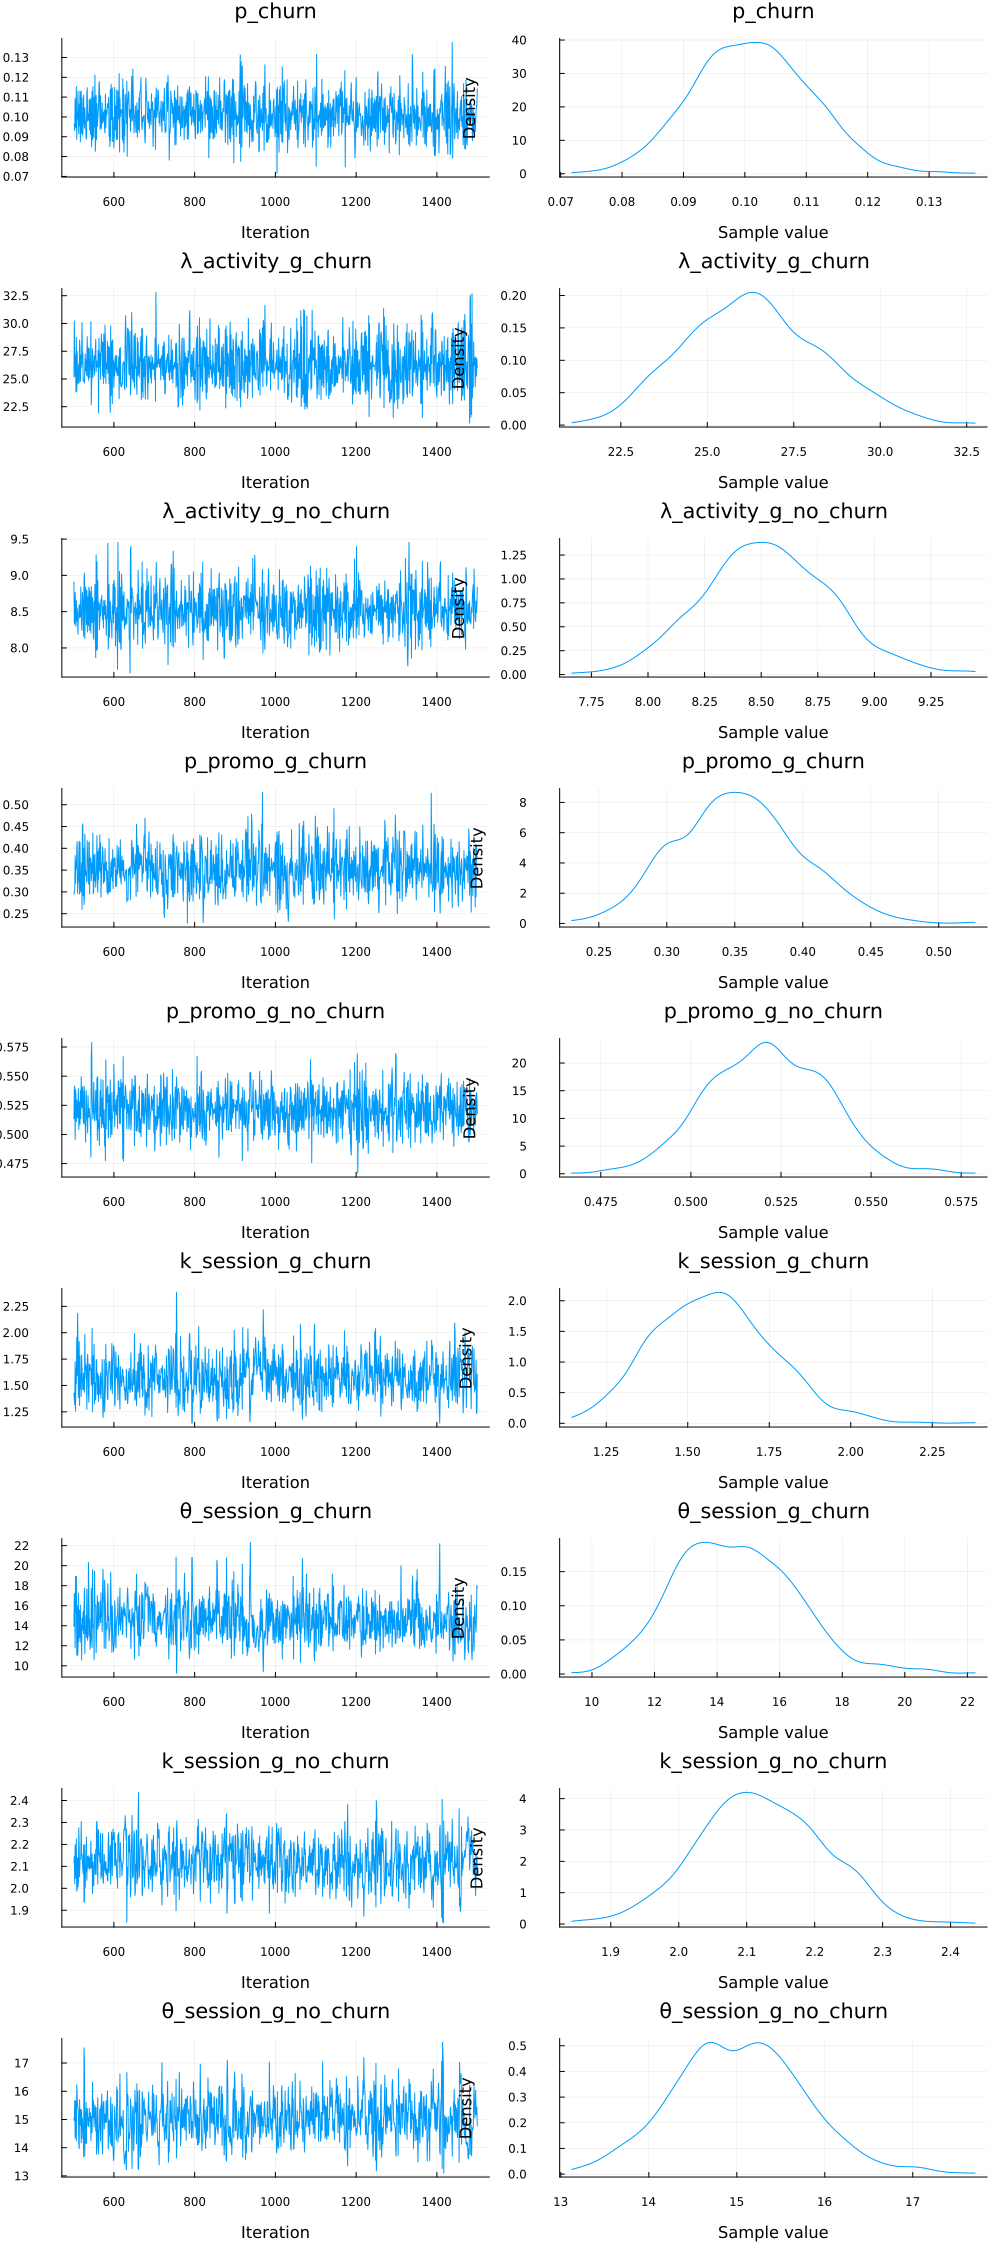

In [15]:
plot(chain)

In [16]:
# 予測機能の実装
function predict_churn(
    chain,
    new_activity,
    new_promotion,
    new_session
)
    n_samples = length(chain)
    predicted_p_churns = zeros(n_samples)

    for i = 1:n_samples
        # 解約率
        p_churn = chain[:p_churn][i]
        p_no_churn = 1 - p_churn
        # 解約グループのパラメータ
        λ_activity_g_churn = chain[:λ_activity_g_churn][i]
        p_promo_g_churn = chain[:p_promo_g_churn][i]
        k_session_g_churn = chain[:k_session_g_churn][i]
        θ_session_g_churn = chain[:θ_session_g_churn][i]
        # 継続グループのパラメータ
        λ_activity_g_no_churn = chain[:λ_activity_g_no_churn][i]
        p_promo_g_no_churn = chain[:p_promo_g_no_churn][i]
        k_session_g_no_churn = chain[:k_session_g_no_churn][i]
        θ_session_g_no_churn = chain[:θ_session_g_no_churn][i]
        # 解約側の尤度計算
        lk_churn = p_churn *
            pdf(Exponential(λ_activity_g_churn), new_activity) *
            pdf(Bernoulli(p_promo_g_churn), new_promotion) *
            pdf(Gamma(k_session_g_churn, θ_session_g_churn), new_session)
        # 継続側の尤度計算
        lk_no_churn = p_no_churn *
            pdf(Exponential(λ_activity_g_no_churn), new_activity) *
            pdf(Bernoulli(p_promo_g_no_churn), new_promotion) *
            pdf(Gamma(k_session_g_no_churn, θ_session_g_no_churn), new_session)
        # 正規化して確率計算
        predicted_p_churns[i] = lk_churn / (lk_churn + lk_no_churn)
    end

    return predicted_p_churns
end

predict_churn (generic function with 1 method)

Mean: 0.9250652379738552


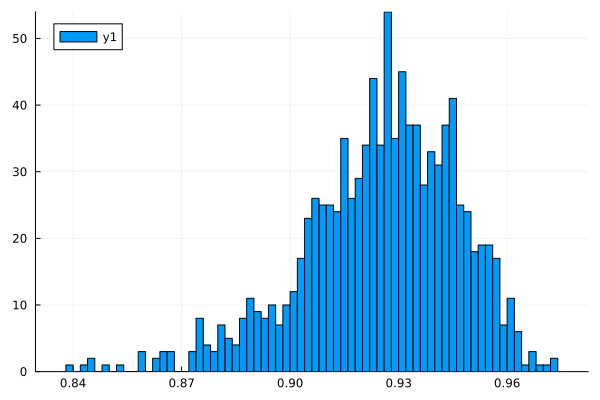

In [17]:
# 解約されそうなデータを入力してみる
# 最終活動から６０日経ち、プロモーションは受けておらず、しかも平均再生時間はわずか５分
r1 = predict_churn(chain, 60, 0, 5)
println("Mean: $(mean(r1))")
histogram(r1, bin=100)

Mean: 0.024346910399093133


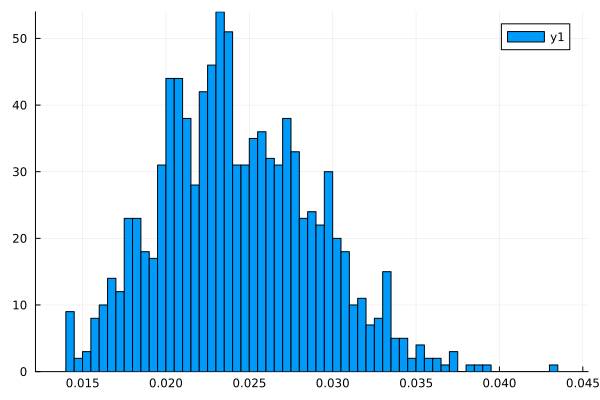

In [18]:
# 継続しそうなグラフ
# 最終活動は３日前、プロモーションは受け取っており、平均再生は３０分
r2 = predict_churn(chain, 3, 1, 30)
println("Mean: $(mean(r2))")
histogram(r2, bin=100)

Mean: 0.018014336473843318
Mean: 0.03545831131026783


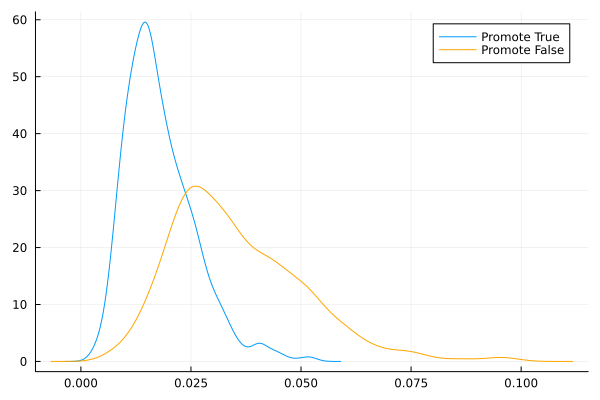

In [19]:
# 解約か継続かが怪しいデータ
# 最後の日付から４０日経過してる。だがプロモーションは受けており、平均再生時間も９０分と長い
r3_1 = predict_churn(chain, 8, 1, 90)
println("Mean: $(mean(r3_1))")
plt_r3_1 = density(
    r3_1,
    bin=100,
    label="Promote True"
)

r3_2 = predict_churn(chain, 8, 0, 90)
println("Mean: $(mean(r3_2))")
plt_r3_2 = density!(
    r3_2,
    bin=100,
    label="Promote False",
    color="orange"
)


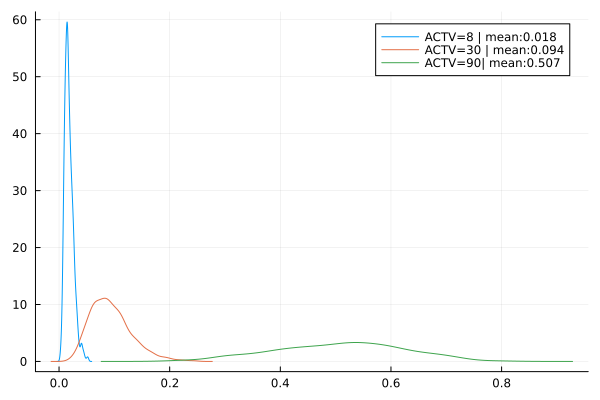

In [20]:
r4_1 = predict_churn(chain, 8, 1, 90)
plt_r4_1 = density(
    r4_1,
    bin=100,
    label="ACTV=8 | mean:$(round(mean(r4_1), digits=3))"
)

r4_2 = predict_churn(chain, 30, 1, 90)
plt_r4_2 = density!(
    r4_2,
    bin=100,
    label="ACTV=30 | mean:$(round(mean(r4_2), digits=3))"
)
r4_3 = predict_churn(chain, 60, 1, 90)
plt_r4_3 = density!(
    r4_3,
    bin=100,
    label="ACTV=90| mean:$(round(mean(r4_3), digits=3))"
)


In [21]:
# using CSV
# CSV.write("streaming.csv", df)

"streaming.csv"